<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline_del_spon_sugar2_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [136]:
!pip install word2vec

In [137]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [138]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

In [139]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

## Train wordvectors

In [140]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [141]:
model.save(wrdvec_path)

In [142]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [143]:
!pip install textsplit

In [144]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [145]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [146]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

71.0212600087405
penalty 55.96
1218 sentences, 16 segments, avg 76.12 sentences per segment
optimal score 39356.85, greedy score 39322.14
[39356.853270857384, 39322.142004759764]
(39356.853270857384, 39322.142004759764)
ratio of scores 1.0009


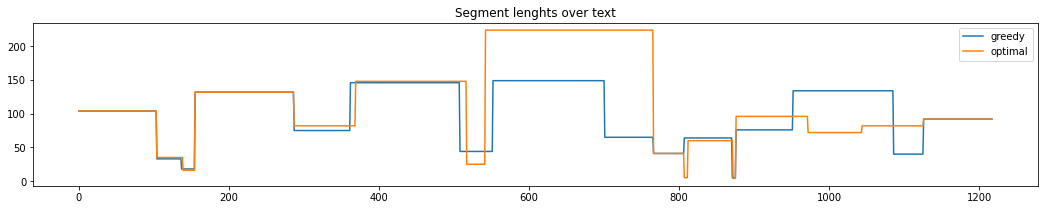

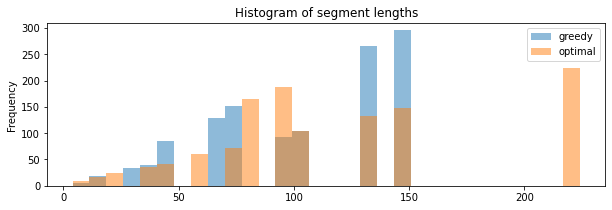

In [147]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)
new_length = len(sentenced_text)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
#penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [148]:
for i in range(len(segmented_text)):
  print(segmented_text[i])
  

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [149]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))
print(first_sentence)
1

Welcome to the huberman Lab podcast. 
<class 'str'>
104
I don't know that there's anyone that really debates that anymore, even if we just agree and I think we should all agree on the so-called calories in calories out, principle of thermodynamics more energy than we burn. 
<class 'str'>
35
Blood. 
<class 'str'>
16
Meaning it's Peaks and it's valleys are more like Smooth it out and that glucose is sequestered. 
<class 'str'>
132
Fructose, of course, is found in fruit. 
<class 'str'>
82
That regulates our appetite for sugar. 
<class 'str'>
148
I'll provide a link to this study in the caption first. 
<class 'str'>
25
In fact, the way these experiments are done is very clever. 
<class 'str'>
224
What they do is they have people and He studies were done in people and just multi dextrin, which increases blood glucose doesn't have much flavor, but even if it Does have a little bit of subtle flavor. 
<class 'str'>
41
So, that's not really a fair experiment or it's not our natural world experi

1

In [150]:
print(sentenced_text)

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

### 處理輸入

In [151]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [152]:
print(podcast_test)

["Welcome to the huberman Lab podcast. We discussed science science basic tools for everyday life. I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. Today. We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. And its various forms is strongly reinforcing. Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. Incidentally sweet taste also make us want to eat more of other substances as well. You may

# Headline generator

In [153]:
! pip install transformers datasets

In [154]:
!pip install sentencepiece

In [155]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [156]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

In [157]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [158]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (2103 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [159]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Huberman Lab Podcast - The Brain Body Contract'}
<class 'dict'>
{'generated_text': 'The Effects of Sugar on the Nervous System'}
<class 'dict'>
{'generated_text': 'Type 1 Diabetes - Insulin Response to Clamp Blood Glucose Level'}
<class 'dict'>
{'generated_text': 'The Importance of Glucose in the Nervous System'}
<class 'dict'>
{'generated_text': 'Is Fructose a Good Thing for Weight Loss?'}
<class 'dict'>
{'generated_text': 'Dopamine and the Pleasure Pain - The Secret of the Mood and'}
<class 'dict'>
{'generated_text': 'The Preference for Sweet Taste in Foods'}
<class 'dict'>
{'generated_text': 'The Effects of Sugary Foods on Your Blood Sugar'}
<class 'dict'>
{'generated_text': 'Is There a Conversion of Artificial Sweeteners?'}
<class 'dict'>
{'generated_text': 'Is That a Fair Experiment Or Is It Not Our Natural World Experi'}
<class 'dict'>
{'generated_text': 'ADHD - Is Sugar Consumption a Good Idea?'}
<class 'dict'>
{'generated_text': 'Sugar, Consumption of Su

In [160]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Huberman Lab Podcast', '-', 'The Brain Body Contract']
['The Huberman Lab Podcast', '-', 'The Brain Body Contract']
<class 'str'>
['The Effects of Sugar on the Nervous System']
['The Effects of Sugar on the Nervous System']
<class 'str'>
['Type 1 Diabetes', '-', 'Insulin Response to Clamp Blood Glucose Level']
['Type 1 Diabetes', '-', 'Insulin Response to Clamp Blood Glucose Level']
<class 'str'>
['The Importance of Glucose in the Nervous System']
['The Importance of Glucose in the Nervous System']
<class 'str'>
['Is Fructose a Good Thing for Weight Loss?']
['Is Fructose a Good Thing for Weight Loss?']
<class 'str'>
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
['Dopamine and the Pleasure Pain', '-', 'The Secret of the Mood and']
<class 'str'>
['The Preference for Sweet Taste in Foods']
['The Preference for Sweet Taste in Foods']
<class 'str'>
['The Effects of Sugary Foods on Your Blood Sugar']
['The Effects of Sugary Foods on Your Blood Sugar']
<class 'st

In [161]:
for headline_string in headlines_string:
  print(headline_string)

 The Huberman Lab Podcast - The Brain Body Contract
 The Effects of Sugar on the Nervous System
 Type 1 Diabetes - Insulin Response to Clamp Blood Glucose Level
 The Importance of Glucose in the Nervous System
 Is Fructose a Good Thing for Weight Loss?
 Dopamine and the Pleasure Pain - The Secret of the Mood and
 The Preference for Sweet Taste in Foods
 The Effects of Sugary Foods on Your Blood Sugar
 Is There a Conversion of Artificial Sweeteners?
 Is That a Fair Experiment Or Is It Not Our Natural World Experi
 ADHD - Is Sugar Consumption a Good Idea?
 Sugar , Consumption of Sugar - Sugar Beverages and
 Can Glutamine Reduce Sugar Cravings?
 How Lemon Juice and Lime Juice Can Decrease Blood Glucose
 The Effects of Berberine on Blood Glucose
 The Importance of Sleep in Controlling Appetite


In [162]:
print(headlines_string)
1

[' The Huberman Lab Podcast - The Brain Body Contract', ' The Effects of Sugar on the Nervous System', ' Type 1 Diabetes - Insulin Response to Clamp Blood Glucose Level', ' The Importance of Glucose in the Nervous System', ' Is Fructose a Good Thing for Weight Loss?', ' Dopamine and the Pleasure Pain - The Secret of the Mood and', ' The Preference for Sweet Taste in Foods', ' The Effects of Sugary Foods on Your Blood Sugar', ' Is There a Conversion of Artificial Sweeteners?', ' Is That a Fair Experiment Or Is It Not Our Natural World Experi', ' ADHD - Is Sugar Consumption a Good Idea?', ' Sugar , Consumption of Sugar - Sugar Beverages and', ' Can Glutamine Reduce Sugar Cravings?', ' How Lemon Juice and Lime Juice Can Decrease Blood Glucose', ' The Effects of Berberine on Blood Glucose', ' The Importance of Sleep in Controlling Appetite']


1

In [163]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [164]:
!pip install -U scikit-learn
!pip install --user -U nltk

In [165]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [166]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [167]:
print(len(result_nltk))
print(result_nltk)

16
["Welcome huberman Lab podcast . We discussed science science basic tools everyday life . I 'm Andrew huberman , I 'm professor neurobiology Ophthalmology Stanford school medicine . Today . We going discuss sugar particular nervous system , regulate , sugar intake seeking sugar . We 're also going discuss sugar regulates nervous system 'll soon , learn sugar really impacts brain body two main mechanism . One mechanisms based Sweet Taste sugar rewarding , even 're much sweet tooth , I confess . I 'm people enjoy sweet taste bitter taste , Sweet Taste sugar . And various forms strongly reinforcing . Meaning triggers activation neurons nerve cells brain body make us want consume sweet substance . Incidentally sweet taste also make us want eat substances well . You may familiar phenomenon . Now sugar also triggers mechanisms brain body based nutritive content independent . Its sweetness . What means actual caloric content way Sugar interacts nervous system subconscious level without awa

In [168]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [169]:
print(len(feature_name_nltk))
print(feature_name_nltk)

2490
['10', '100', '11', '12', '15', '17th', '18th', '1st', '20', '2012', '30', '3s', '45', '46', '50', '55', '70', '750', '80', '88th', '90', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'abundance', 'abundant', 'accelerator', 'accelerators', 'accept', 'access', 'accident', 'accounting', 'acetylcholine', 'achieve', 'achieving', 'acid', 'acidic', 'acidity', 'acids', 'acknowledge', 'across', 'acting', 'action', 'actionable', 'actions', 'activate', 'activating', 'activation', 'active', 'activities', 'activity', 'actual', 'actually', 'adapted', 'addiction', 'addictive', 'addition', 'additional', 'adhd', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'adrenaline', 'adult', 'adults', 'advanced', 'advantage', 'advantageous', 'affect', 'after', 'ag1', 'again', 'agitated', 'agree', 'agrees', 'ahead', 'aiming', 'alert', 'alkaline', 'alkalinity', 'all', 'allergy', 'allow', 'allowing', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'alter', 'although', 'always', 'am', 'amaz

In [172]:
for i in range(len(feature_name_nltk)):
  try:
    s = model.similarity('sponsor',feature_name_nltk[i])
    print(feature_name_nltk[i],end=" ")
    print(s)
  except:
    pass
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


ability 0.13789278
able 0.2005051
absence -0.0041580815
absolute -0.087022595
absolutely 0.1141049
abundance -0.20480198
abundant -0.06308687
accelerator 0.012218354
accelerators -0.016633091
accept 0.108952
access 0.1131918
accident 0.13228957
accounting 0.12102339
acetylcholine 0.024618294
achieve 0.11753696
achieving 0.22479658
acid -0.014803856
acidic 0.00402771
acidity 0.03625449
acids -0.060514204
acknowledge 0.20475009
across 0.019622708
acting 0.1341964
action 0.11294842
actions 0.0842459
activate 0.09564205
activating 0.08534855
activation 0.065609306
active 0.25816715
activities 0.29389557
activity 0.10735186
actual 0.047033094
actually 0.035129618
adapted -0.17091952
addiction 0.17358495
addictive 0.18561223
addition 0.24216555
additional 0.09298766
adhd 0.18789072
adjust 0.09711787
adjusted 0.10813152
adjusting 0.17169675
adjustment 0.15228464
adrenaline 0.14912607
adult 0.001734128
adults 0.12008149
advanced 0.122966915
advantage 0.07454282
advantageous 0.08346623
affect 0

In [ ]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

In [ ]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

In [ ]:
print(keyword_segment)
print(tfidf_segment)

In [ ]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w or "sponsors" == w or "Sponsor" == w or "Sponsors" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

In [ ]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

## 篩選出名詞和形容詞

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

In [ ]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [ ]:
select_word

## 去掉sponsor

In [ ]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

In [ ]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num-1)>=i): is_sponsor.append(sentenced_text[j-num-1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

In [ ]:
for sent in is_sponsor: 
  print(sent)

In [ ]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

# 重新來分段一次

In [ ]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [ ]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

In [ ]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [ ]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

In [ ]:
for headline in headlines:
  print(headline)
  

In [ ]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

In [ ]:
for headline_string in headlines_string:
  print(headline_string)

In [ ]:
len(headlines_string)

In [ ]:
print(headlines_string)
3

In [ ]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

In [ ]:
print(first_sentence)
print(len((first_sentence)))